<a href="https://colab.research.google.com/github/antonioalbanese/Time-Series-Anomaly-Detection-An-experimental-survey/blob/main/Experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchinfo --quiet

!pip install wandb --quiet

import os
os.environ["WANDB_API_KEY"] = "571001027d1947e02fe01237fe2d0bf5bbf8071b"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 13.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 KB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 6.2 MB/s eta 0:00:00


In [2]:
import zipfile
import numpy as np


!pip install torchinfo --quiet

!git clone https://github.com/antonioalbanese/Time-Series-Anomaly-Detection-An-experimental-survey/

%cd Time-Series-Anomaly-Detection-An-experimental-survey

%mkdir data

%mkdir ./data/SMD
!python USAD/gdrivedl.py https://drive.google.com/file/d/18JNYBsaX7tu0Qfgo92nCBCklv471L1xB data/SMD
with zipfile.ZipFile("./data/SMD/SMD.zip", 'r') as zip_ref:
    zip_ref.extractall("./data/")

%mkdir ./data/MSL
!python USAD/gdrivedl.py https://drive.google.com/uc?id=1ZCLBU_pKTbsPlcj_LwxZE3IRy6mrlys3 data/MSL
with zipfile.ZipFile("./data/MSL/MSL.zip", 'r') as zip_ref:
    zip_ref.extractall("./data/")

!mkdir data/SWAT
#normal period
!python USAD/gdrivedl.py https://drive.google.com/open?id=1rVJ5ry5GG-ZZi5yI4x9lICB8VhErXwCw data/SWAT
#anomalies
!python USAD/gdrivedl.py https://drive.google.com/open?id=1iDYc0OEmidN712fquOBRFjln90SbpaE7 data/SWAT

Cloning into 'Time-Series-Anomaly-Detection-An-experimental-survey'...
remote: Enumerating objects: 1485, done.
remote: Counting objects: 100% (295/295), done.
remote: Compressing objects: 100% (195/195), done.
remote: Total 1485 (delta 186), reused 157 (delta 100), pack-reused 1190
Receiving objects: 100% (1485/1485), 11.35 MiB | 10.25 MiB/s, done.
Resolving deltas: 100% (925/925), done.
/content/Time-Series-Anomaly-Detection-An-experimental-survey
data/SMD/SMD.zip
[==================================================] 185.82MB/185.82MB
data/MSL/MSL.zip
[==================================================] 0.73MB/0.73MB
data/SWAT/SWaT_Dataset_Normal_v1.csv
[==================================================] 163.77MB/163.77MB
data/SWAT/SWaT_Dataset_Attack_v0.csv
[==================================================] 127.27MB/127.27MB


# DATASET DECRIPTION

## PLOT DENSITY AND RUG FOR NAB_TRAFFIC



<ipython-input-73-8eaa7e7b6049>:23: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df['value'], shade=True)


<Axes: xlabel='value', ylabel='Density'>

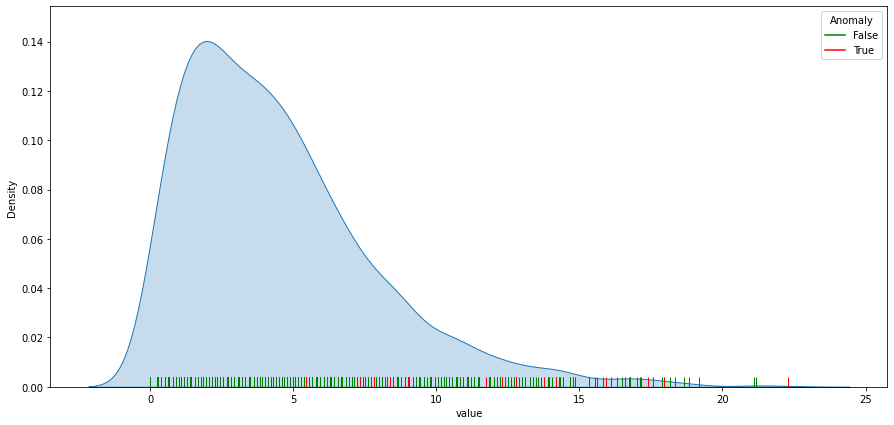

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
with open("./NAB/combined_windows.json") as FI:
  j_label = json.load(FI)

data_path = "realTraffic/occupancy_6005.csv"
key = data_path
windows = j_label[key]
df = pd.read_csv("./NAB/" + data_path)
df['timestamp'] = pd.to_datetime(df['timestamp'])
ground_truth = np.zeros(len(df), dtype=bool)
for w in windows:
  start = pd.to_datetime(w[0])
  end = pd.to_datetime(w[1])
  for idx in df.index:
    if df.loc[idx, 'timestamp'] >= start and df.loc[idx, 'timestamp'] <= end:
      ground_truth[idx] = True
df['Anomaly'] = ground_truth

fig = plt.figure(figsize=(15,7))
sns.kdeplot(data=df['value'], shade=True)
sns.rugplot(data=df, x='value', hue='Anomaly', palette=['green','red'])

## PLOT DENSITY AND RUG FOR NAB_AD

<ipython-input-74-4988b8523685>:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df['value'], shade=True)


<Axes: xlabel='value', ylabel='Density'>

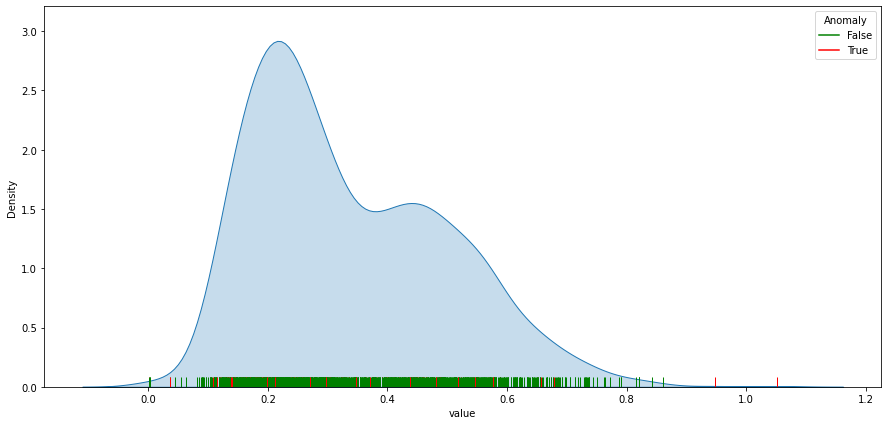

In [ ]:
data_path = "realAdExchange/exchange-2_cpm_results.csv"
key = data_path
windows = j_label[key]
df = pd.read_csv("./NAB/" + data_path)
df['timestamp'] = pd.to_datetime(df['timestamp'])
ground_truth = np.zeros(len(df), dtype=bool)
for w in windows:
  start = pd.to_datetime(w[0])
  end = pd.to_datetime(w[1])
  for idx in df.index:
    if df.loc[idx, 'timestamp'] >= start and df.loc[idx, 'timestamp'] <= end:
      ground_truth[idx] = True
df['Anomaly'] = ground_truth

fig = plt.figure(figsize=(15,7))
sns.kdeplot(data=df['value'], shade=True)
sns.rugplot(data=df, x='value', hue='Anomaly', palette=['green','red'])

## PLOT DENSITY AND RUG FOR NAB_TEMP

<ipython-input-72-ae6776339a96>:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df['value'], shade=True)


<Axes: xlabel='value', ylabel='Density'>

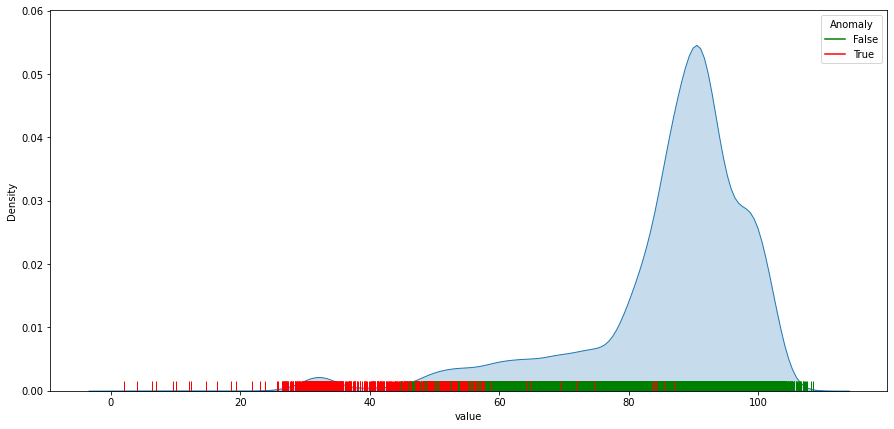

In [ ]:
data_path = "realKnownCause/machine_temperature_system_failure.csv"
key = data_path
windows = j_label[key]
df = pd.read_csv("./NAB/" + data_path)
df['timestamp'] = pd.to_datetime(df['timestamp'])
ground_truth = np.zeros(len(df), dtype=bool)
for w in windows:
  start = pd.to_datetime(w[0])
  end = pd.to_datetime(w[1])
  for idx in df.index:
    if df.loc[idx, 'timestamp'] >= start and df.loc[idx, 'timestamp'] <= end:
      ground_truth[idx] = True
df['Anomaly'] = ground_truth

fig = plt.figure(figsize=(15,7))
sns.kdeplot(data=df['value'], shade=True)
sns.rugplot(data=df, x='value', hue='Anomaly', palette=['green','red'])

## PLOT CATEGORICAL DISTRIBUTIN FOR SWAT

<ipython-input-65-89c3e2a23797>:5: DtypeWarning: Columns (1,9,28,46) have mixed types. Specify dtype option on import or set low_memory=False.
  data_swat = pd.read_csv("data/SWAT/SWaT_Dataset_Attack_v0.csv", sep=";")


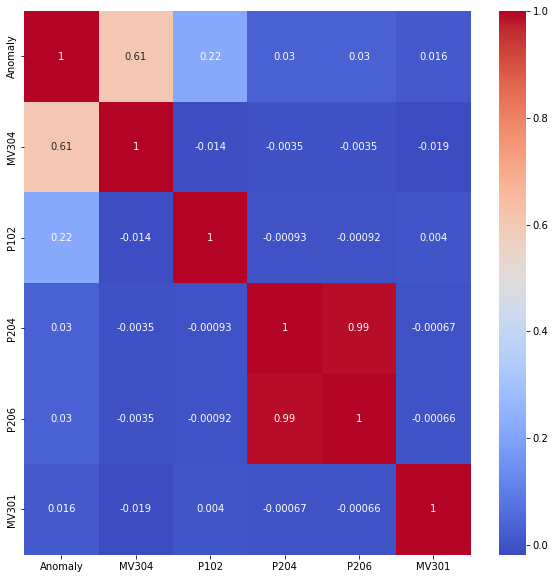

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
data_swat = pd.read_csv("data/SWAT/SWaT_Dataset_Attack_v0.csv", sep=";")
data_swat.columns = ['Timestamp', 'FIT101', 'LIT101', 'MV101', 'P101', 'P102', 'AIT201',
       'AIT202', 'AIT203', 'FIT201', 'MV201', 'P201', 'P202', 'P203', 'P204',
       'P205', 'P206', 'DPIT301', 'FIT301', 'LIT301', 'MV301', 'MV302',
       'MV303', 'MV304', 'P301', 'P302', 'AIT401', 'AIT402', 'FIT401',
       'LIT401', 'P401', 'P402', 'P403', 'P404', 'UV401', 'AIT501', 'AIT502',
       'AIT503', 'AIT504', 'FIT501', 'FIT502', 'FIT503', 'FIT504', 'P501',
       'P502', 'PIT501', 'PIT502', 'PIT503', 'FIT601', 'P601', 'P602', 'P603',
       'Anomaly']
data_swat['Anomaly'] = data_swat['Anomaly'].replace({
    'Attack': True,
    'A ttack': True,
    'Normal': False
})
fig = plt.figure(figsize=(10,10))
corr = data_swat.corr()

target_feature = 'Anomaly'
top_corr_features = corr[target_feature].sort_values(ascending=False)[0:6].index
corr_top_features = data_swat[top_corr_features].corr()
sns.heatmap(corr_top_features, annot=True, cmap='coolwarm')
plt.show()




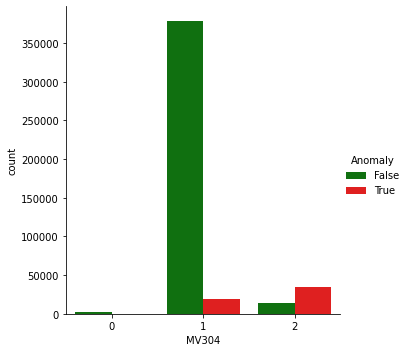

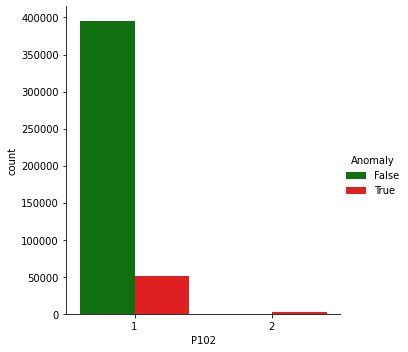

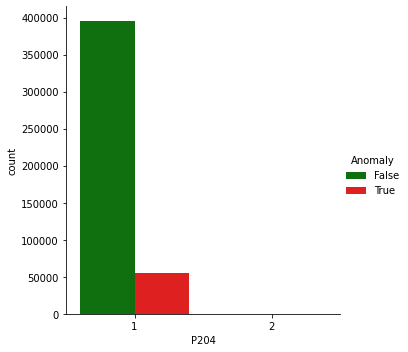

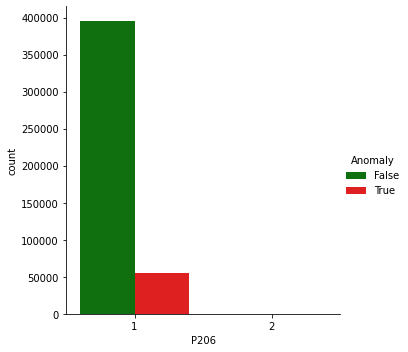

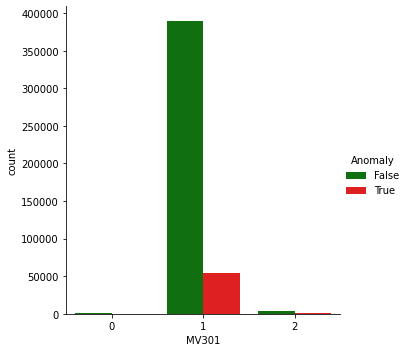

In [ ]:
for f in top_corr_features.drop('Anomaly'):
  sns.catplot(x=f, hue='Anomaly', kind='count', data=data_swat, palette = ['green', 'red'])
  plt.show()

## PLOT DENSITY AND RUG FOR SMD

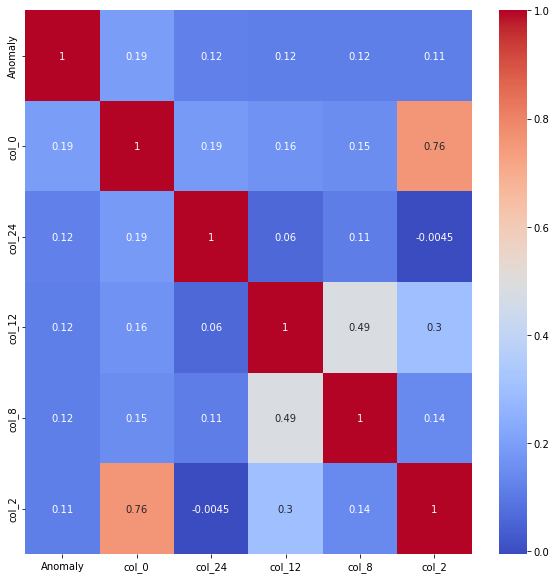

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
data = pd.DataFrame(np.load("data/SMD/SMD_test.npy"))
data.columns = ["col_{}".format(c) for c in data.columns]
labels = np.load("data/SMD/SMD_test_label.npy")
data['Anomaly'] = labels


fig = plt.figure(figsize=(10,10))
corr = data.corr()
target_feature = 'Anomaly'
top_corr_features = corr[target_feature].sort_values(ascending=False)[0:6].index
corr_top_features = data[top_corr_features].corr()
sns.heatmap(corr_top_features, annot=True, cmap='coolwarm')
plt.show()

data.loc[data['Anomaly']==1, 'Anomaly'] = True
data.loc[data['Anomaly']==0, 'Anomaly'] = False

In [ ]:
melted = data[top_corr_features].reset_index().melt(id_vars=['index','Anomaly'], var_name='cols', value_name='vals')

<Axes: xlabel='vals', ylabel='cols'>

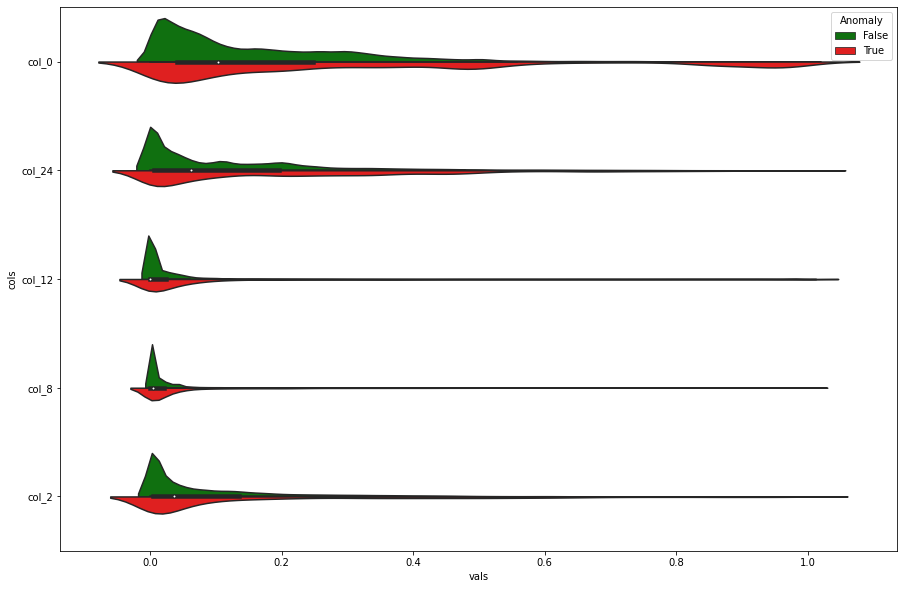

In [ ]:
fig = plt.figure(figsize=(15,10))
sns.violinplot(data=melted, y="cols", x='vals', hue="Anomaly", split=True, palette=['green','red'])

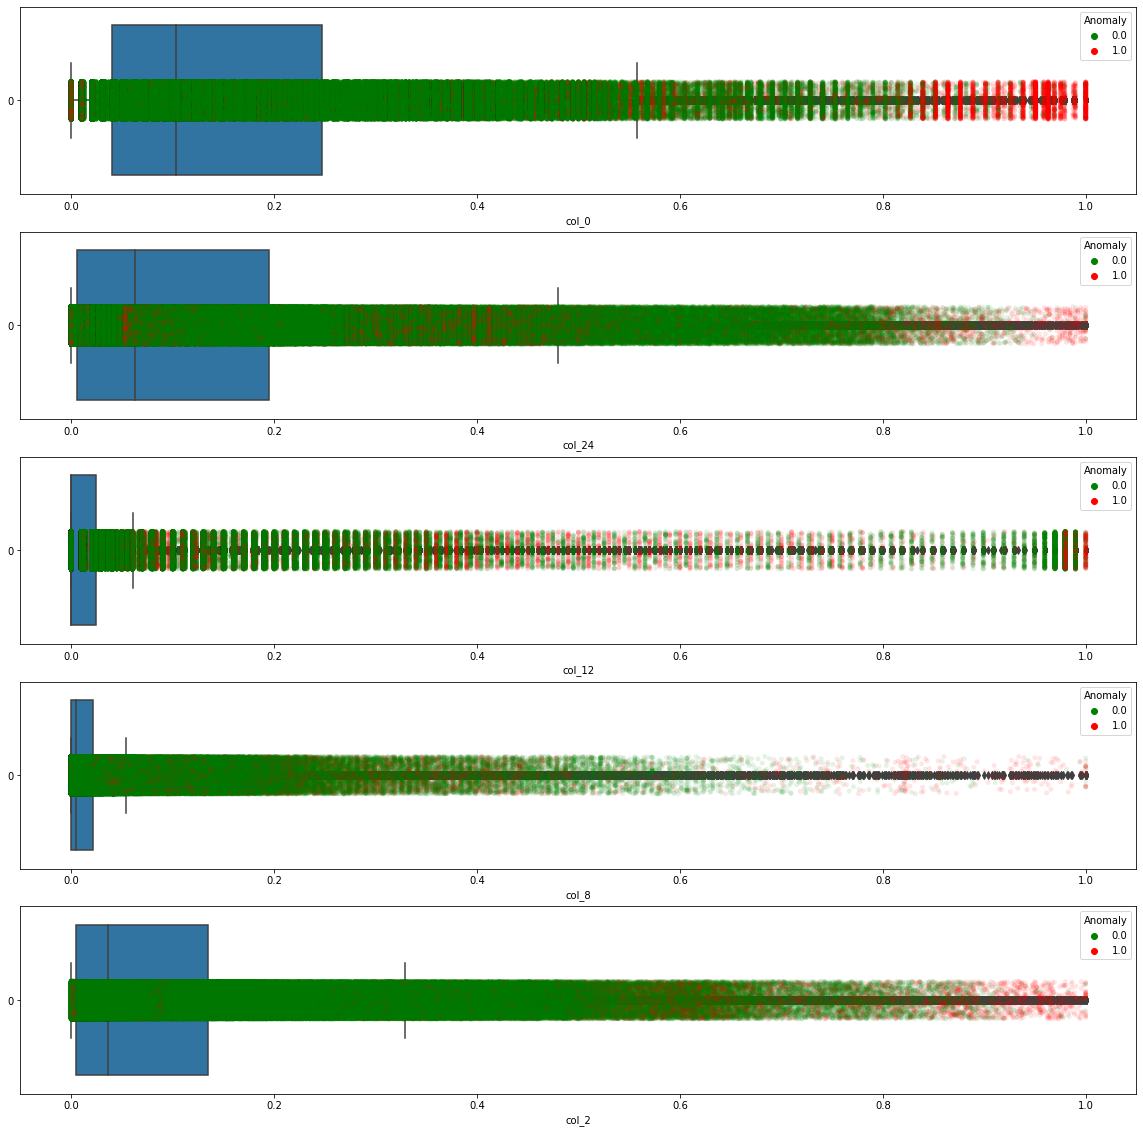

In [ ]:
fig, axs = plt.subplots(ncols=1, nrows=5, figsize=(20, 20))
for ax,f in zip(axs, top_corr_features.drop('Anomaly')):
  sns.boxplot(data[f], orient='h', ax=ax)
  sns.stripplot(data=data[[f,'Anomaly']], x=f, hue='Anomaly', palette=['green','red'], ax=ax, alpha=0.1)
plt.show()


## PLOT DENSITY WITH RUG AND CATEGORICAL DISTRIBUTION FOR MSL

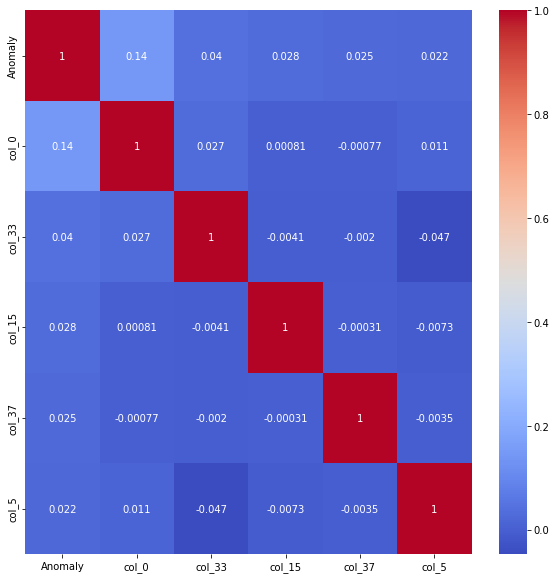

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
data = pd.DataFrame(np.load("data/MSL/MSL_test.npy"))
data.columns = ["col_{}".format(c) for c in data.columns]
labels = np.load("data/MSL/MSL_test_label.npy")
data['Anomaly'] = labels
data.loc[data['Anomaly']==1, 'Anomaly'] = True
data.loc[data['Anomaly']==0, 'Anomaly'] = False

fig = plt.figure(figsize=(10,10))
corr = data.corr()

target_feature = 'Anomaly'
top_corr_features = corr[target_feature].sort_values(ascending=False)[0:6].index
corr_top_features = data[top_corr_features].corr()
sns.heatmap(corr_top_features, annot=True, cmap='coolwarm')
plt.show()

<Axes: xlabel='col_0'>

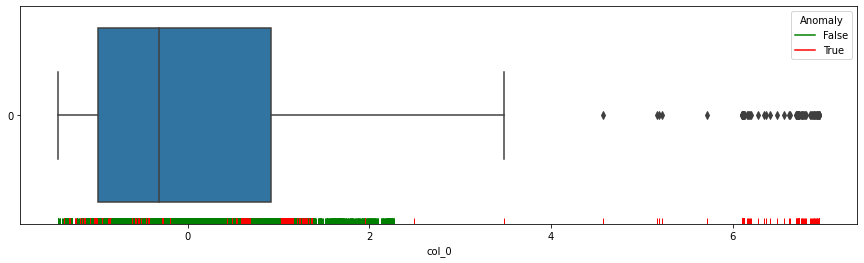

In [ ]:
fig = plt.figure(figsize=(15, 4))
sns.boxplot(data['col_0'][data['col_0']<50], orient='h')
sns.rugplot(data=data[['col_0','Anomaly']][data['col_0']<50], x='col_0', hue='Anomaly', palette=['green','red'])



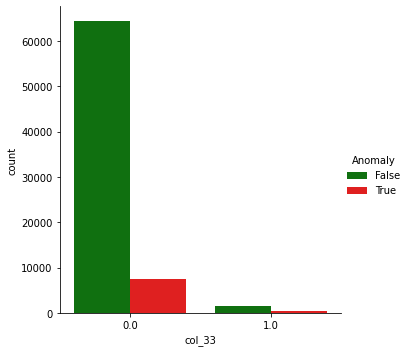

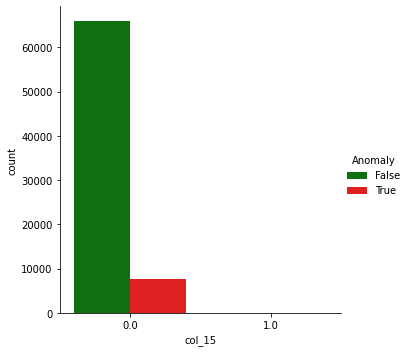

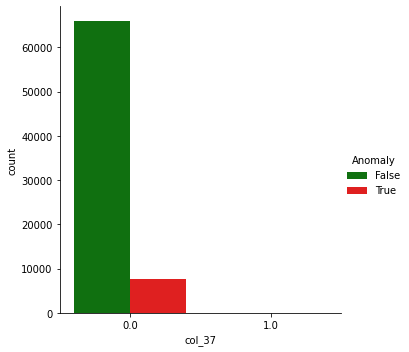

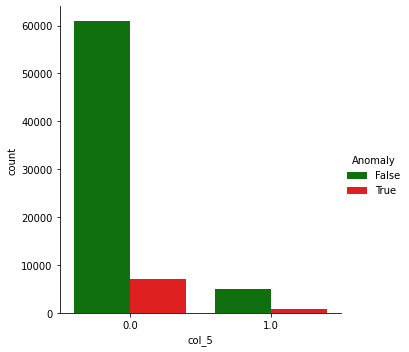

In [ ]:
for f in top_corr_features.drop(['Anomaly','col_0']):
  sns.catplot(x=f, hue='Anomaly', kind='count', data=data, palette=['green', 'red'])
  plt.show()

# ANOMALY SCORES PLOT 

In [29]:
from AnomalyDetectionMethodClass import ADMethod
import csv

LRs = {
    'TRANSFORMER': 0.001,
    'TANOGAN': 0.0001,
    'USAD': 0.0001,
    'DEEPANT':  0.000001 
}


E = {
    'TRANSFORMER': 20,
    'TANOGAN': 30,
    'USAD': 30,
    'DEEPANT':  100 
}

DATASET = 'SMD'
SEQ_LEN = 30
SEED = 1
METHOD = 'TRANSFORMER'
LR = LRs[METHOD]
EPOCHS = E[METHOD]
 

configuration = {
      'DATASET': DATASET,
      'SEQ_LEN': SEQ_LEN,
      'STEP': SEQ_LEN,
      'SEED': SEED,
      'HIDDEN_SIZE': 100, 
      'LR': LR,
      'EPOCHS': EPOCHS,
      'VERBOSE': True,
      'LOGGER': False,
      'K': 3
    }


# configuration = configurations[curr_config]
method = ADMethod(name = METHOD, config = configuration)
train_history = method.train()
_, score = method.test()
rep = method.results(0.6, False)
mu_anomaly = method.anomalies[method.ground].mean()
mu_normal = method.anomalies[~method.ground].mean()
mu_anomaly - mu_normal

with open("{}_{}_mu.csv".format(DATASET, METHOD), 'w', encoding='UTF8') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(['kind','mu_anomalies', 'mu_normal', 'score'])

    mu_a = (method.scores[method.ground_s]).mean()
    mu_n = (method.scores[~method.ground_s]).mean()
    writer.writerow(['1', mu_a, mu_n, mu_a-mu_n])

    mu_a = (method.scores[method.ground_s]*1.5).mean()
    mu_n = (method.scores[~method.ground_s]).mean()
    writer.writerow(['1.5', mu_a, mu_n, mu_a-mu_n])

    mu_a = (method.scores[method.ground_s]*2).mean()
    mu_n = (method.scores[~method.ground_s]).mean()
    writer.writerow(['2', mu_a, mu_n, mu_a-mu_n])

from google.colab import files
files.download("{}_{}_mu.csv".format(DATASET, METHOD)) 

Initializing...
Data preprocessing and method configuration finished in 0.5377218723297119 sec.
Model summary: 
Layer (type:depth-idx)                             Param #
AnomalyTransformer                                 --
├─DataEmbedding: 1-1                               --
│    └─TokenEmbedding: 2-1                         --
│    │    └─Conv1d: 3-1                            58,368
│    └─PositionalEmbedding: 2-2                    --
│    └─Dropout: 2-3                                --
├─Encoder: 1-2                                     --
│    └─ModuleList: 2-4                             --
│    │    └─EncoderLayer: 3-2                      1,583,112
│    │    └─EncoderLayer: 3-3                      1,583,112
│    │    └─EncoderLayer: 3-4                      1,583,112
│    └─LayerNorm: 2-5                              1,024
├─Linear: 1-3                                      19,494
Total params: 4,828,222
Trainable params: 4,828,222
Non-trainable params: 0
Training...


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning:

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



Epoch 1/20: train_loss_1:-19.94838. train_loss_2:20.75811
Epoch 2/20: train_loss_1:-16.67581. train_loss_2:18.39979
Epoch 3/20: train_loss_1:-17.96298. train_loss_2:18.76367
Epoch 4/20: train_loss_1:-22.00855. train_loss_2:22.44668
Epoch 5/20: train_loss_1:-31.30312. train_loss_2:31.51385
Epoch 6/20: train_loss_1:-37.14075. train_loss_2:37.39628
Epoch 7/20: train_loss_1:-39.44355. train_loss_2:39.57743
Epoch 8/20: train_loss_1:-40.93932. train_loss_2:41.08289
Epoch 9/20: train_loss_1:-41.95818. train_loss_2:42.04409
Epoch 10/20: train_loss_1:-42.92981. train_loss_2:42.98907
Epoch 11/20: train_loss_1:-43.84906. train_loss_2:43.91157
Epoch 12/20: train_loss_1:-44.57423. train_loss_2:44.63955
Epoch 13/20: train_loss_1:-45.17781. train_loss_2:45.23203
Epoch 14/20: train_loss_1:-45.72912. train_loss_2:45.77296
Epoch 15/20: train_loss_1:-46.05814. train_loss_2:46.09929
Epoch 16/20: train_loss_1:-46.32379. train_loss_2:46.36868
Epoch 17/20: train_loss_1:-46.64679. train_loss_2:46.68998
Epoch 

IndexError: ignored

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
rep = method.results(0.6, True)

Computing results... 
              precision    recall  f1-score   support

       False       0.96      0.87      0.91      2161
        True       0.44      0.73      0.55       295

    accuracy                           0.85      2456
   macro avg       0.70      0.80      0.73      2456
weighted avg       0.90      0.85      0.87      2456



#EXPERIMENTS

In [ ]:
!wandb sweep ../prova.yaml -p new_prova -e ai4trucks-anomalydetection  --name finale_TRANSFORMER

wandb: Creating sweep from: ../prova.yaml
wandb: Created sweep with ID: 4q0r64p2
wandb: View sweep at: https://wandb.ai/ai4trucks-anomalydetection/new_prova/sweeps/4q0r64p2
wandb: Run sweep agent with: wandb agent ai4trucks-anomalydetection/new_prova/4q0r64p2


In [ ]:
!wandb agent ai4trucks-anomalydetection/new_prova/4q0r64p2

wandb: Starting wandb agent 🕵️
2023-01-29 20:10:18,137 - wandb.wandb_agent - INFO - Running runs: []
2023-01-29 20:10:18,415 - wandb.wandb_agent - INFO - Agent received command: run
2023-01-29 20:10:18,415 - wandb.wandb_agent - INFO - Agent starting run with config:
	DATASET: NAB
	DOWNLOAD_DS: False
	EPOCHS: 30
	HIDDEN_SIZE: 100
	LOGGER: False
	LR: 0.0001
	METHOD: TRANSFORMER
	NAB_PATH: realAdExchange/exchange-2_cpm_results.csv
	SEED: 1
	SEQ_LEN: 30
	STEP: 30
	VERBOSE: False
2023-01-29 20:10:18,417 - wandb.wandb_agent - INFO - About to run command: /usr/bin/env python main.py --DATASET=NAB --DOWNLOAD_DS=False --EPOCHS=30 --HIDDEN_SIZE=100 --LOGGER=False --LR=0.0001 --METHOD=TRANSFORMER --NAB_PATH=realAdExchange/exchange-2_cpm_results.csv --SEED=1 --SEQ_LEN=30 --STEP=30 --VERBOSE=False
2023-01-29 20:10:23,426 - wandb.wandb_agent - INFO - Running runs: ['n6su7gl1']
Initializing...
Traceback (most recent call last):
  File "main.py", line 67, in <module>
    method = ADMethod(name = args.

In [ ]:
!python main.py "TRANSFORMER" "NAB" "realAdExchange/exchange-2_cpm_results.csv" 100 100 0.001 30 True False 100 1 False

mkdir: cannot create directory ‘./data’: File exists
Initializing...
wandb: Currently logged in as: michiamoantonio. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.13.9
wandb: Run data is saved locally in /content/Time-Series-Anomaly-Detection-An-experimental-survey/wandb/run-20230129_173946-TRAINING___TRANSFORMER_NAB-seqlen_100-step_100-epochs_30
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run TRAINING___TRANSFORMER_NAB-seqlen_100-step_100-epochs_30
wandb: ⭐️ View project at https://wandb.ai/michiamoantonio/experimental-survey-AD
wandb: 🚀 View run at https://wandb.ai/michiamoantonio/experimental-survey-AD/runs/TRAINING___TRANSFORMER_NAB-seqlen_100-step_100-epochs_30
NAB DS
NAB DS
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is go

## TANOGAN

In [ ]:
### NEW TANOGAN 
from AnomalyDetectionMethodClass import ADMethod

configuration = {
    'DATASET': 'SMD', #SWAT, MSL, SMD, NAB
    'DATAPATH': "realKnownCause/machine_temperature_system_failure.csv", #"realKnownCause/machine_temperature_system_failure.csv", #Only needed with NAB
    'SEQ_LEN': 300,
    'STEP': 300,
    'HIDDEN_SIZE': 100, #Needed for USAD method
    'LR': 0.0001,
    'EPOCHS': 30,
    'VERBOSE': True,
    'LOGGER': False
}
# configuration = configurations[curr_config]
method = ADMethod(name = 'TANOGAN', config = configuration)
train_history = method.train()
_, score = method.test()
rep = method.results(0.6, True)

Initializing...
Data preprocessing and method configuration finished in 0.4700429439544678 sec.
Model summary: 
Generator: 
Layer (type:depth-idx)                   Param #
TanoLSTMGenerator                        --
├─LSTM: 1-1                              9,216
├─LSTM: 1-2                              25,088
├─LSTM: 1-3                              99,328
├─Sequential: 1-4                        --
│    └─Linear: 2-1                       4,902
│    └─Tanh: 2-2                         --
Total params: 138,534
Trainable params: 138,534
Non-trainable params: 0
Discriminator: 
Layer (type:depth-idx)                   Param #
TanoLSTMDiscriminator                    --
├─LSTM: 1-1                              56,000
├─Sequential: 1-2                        --
│    └─Linear: 2-1                       101
│    └─Sigmoid: 2-2                      --
Total params: 56,101
Trainable params: 56,101
Non-trainable params: 0
Training...


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning:

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.

/content/Time-Series-Anomaly-Detection-An-experimental-survey/AnomalyDetectionMethodClass.py:610: UserWarning:

nn.init.normal is now deprecated in favor of nn.init.normal_.

/content/Time-Series-Anomaly-Detection-An-experimental-survey/AnomalyDetectionMethodClass.py:626: UserWarning:

nn.init.normal is now deprecated in favor of nn.init.normal_.



Epoch 1/30: train_loss_D:1.36293. train_loss_G:0.67411
Epoch 2/30: train_loss_D:1.33716. train_loss_G:0.65777
Epoch 3/30: train_loss_D:1.30986. train_loss_G:0.63177
Epoch 4/30: train_loss_D:1.28369. train_loss_G:0.56502
Epoch 5/30: train_loss_D:1.48588. train_loss_G:0.37473
Epoch 6/30: train_loss_D:1.88256. train_loss_G:0.27434
Epoch 7/30: train_loss_D:1.76728. train_loss_G:0.33412
Epoch 8/30: train_loss_D:1.54230. train_loss_G:0.45359
Epoch 9/30: train_loss_D:1.30133. train_loss_G:0.63121
Epoch 10/30: train_loss_D:1.09395. train_loss_G:0.82604
Epoch 11/30: train_loss_D:0.86024. train_loss_G:0.98559
Epoch 12/30: train_loss_D:0.74351. train_loss_G:1.02049
Epoch 13/30: train_loss_D:1.45597. train_loss_G:0.53680
Epoch 14/30: train_loss_D:1.60097. train_loss_G:0.47769
Epoch 15/30: train_loss_D:1.51580. train_loss_G:0.48774
Epoch 16/30: train_loss_D:1.44435. train_loss_G:0.47266
Epoch 17/30: train_loss_D:1.26642. train_loss_G:0.44420
Epoch 18/30: train_loss_D:1.14981. train_loss_G:0.47301
E

/content/Time-Series-Anomaly-Detection-An-experimental-survey/AnomalyDetectionMethodClass.py:736: UserWarning:

nn.init.normal is now deprecated in favor of nn.init.normal_.



Test finished in 1107.208 sec.
Computing results... 
              precision    recall  f1-score   support

       False       0.88      0.97      0.92      3076
        True       0.34      0.11      0.16       466

    accuracy                           0.86      3542
   macro avg       0.61      0.54      0.54      3542
weighted avg       0.81      0.86      0.82      3542



In [ ]:
rep = method.results(0.42, True)

Computing results... 


<ipython-input-8-342a09e8d8f1>:1: DtypeWarning:

Columns (1,9,28,46) have mixed types.Specify dtype option on import or set low_memory=False.



              precision    recall  f1-score   support

       False       0.96      1.00      0.98      3917
        True       0.98      0.69      0.81       582

    accuracy                           0.96      4499
   macro avg       0.97      0.84      0.89      4499
weighted avg       0.96      0.96      0.95      4499



## TRANSFORMER

In [ ]:
### NEW TRANSFORMER 
from AnomalyDetectionMethodClass import ADMethod

configuration = {
    'DATASET': 'NAB', #SWAT, MSL, SMD, NAB
    'DATAPATH': "realAdExchange/exchange-2_cpm_results.csv", #"realKnownCause/machine_temperature_system_failure.csv", #Only needed with NAB
    'SEQ_LEN': 100,
    'STEP': 100,
    'HIDDEN_SIZE': 100, #Needed for USAD method
    'LR': 0.001,
    'EPOCHS': 20,
    'K': 3, 
    'VERBOSE': True,
    'LOGGER': False
}
# configuration = configurations[curr_config]
method = ADMethod(name = 'TRANSFORMER', config = configuration)
train_history = method.train()
_, score = method.test()
rep = method.results(0.6, True)

Initializing...
NAB DS
NAB DS


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Data preprocessing and method configuration finished in 5.2544639110565186 sec.
Model summary: 
Layer (type:depth-idx)                             Param #
AnomalyTransformer                                 --
├─DataEmbedding: 1-1                               --
│    └─TokenEmbedding: 2-1                         --
│    │    └─Conv1d: 3-1                            1,536
│    └─PositionalEmbedding: 2-2                    --
│    └─Dropout: 2-3                                --
├─Encoder: 1-2                                     --
│    └─ModuleList: 2-4                             --
│    │    └─EncoderLayer: 3-2                      1,583,112
│    │    └─EncoderLayer: 3-3                      1,583,112
│    │    └─EncoderLayer: 3-4                      1,583,112
│    └─LayerNorm: 2-5                              1,024
├─Linear: 1-3                                      513
Total params: 4,752,409
Trainable params: 4,752,409
Non-trainable params: 0
Training...
Epoch 1/20: train_loss_1:-2

In [ ]:
rep = method.results(0.9, True)

Computing results... 
              precision    recall  f1-score   support

       False       0.93      0.93      0.93        27
        True       0.60      0.60      0.60         5

    accuracy                           0.88        32
   macro avg       0.76      0.76      0.76        32
weighted avg       0.88      0.88      0.88        32



## USAD

In [ ]:
### NEW USAD 
from AnomalyDetectionMethodClass import ADMethod

configuration = {
    'DATASET': 'NAB', #SWAT, MSL, SMD, NAB
    'DATAPATH': "realKnownCause/machine_temperature_system_failure.csv", #"realKnownCause/machine_temperature_system_failure.csv", #Only needed with NAB
    'SEQ_LEN': 100,
    'STEP': 100,
    'HIDDEN_SIZE': 100, #Needed for USAD method
    'LR': 0.0001,
    'EPOCHS': 1, 
    'VERBOSE': True,
    'LOGGER': False
}
# configuration = configurations[curr_config]
method = ADMethod(name = 'USAD', config = configuration)
train_history = method.train()
_, score = method.test()
rep = method.results(0.5, True)

## DEEPANT

In [ ]:
### NEW DEEPANT 
from AnomalyDetectionMethodClass import ADMethod

configuration = {
    'DATASET': 'SWAT', #SWAT, MSL, SMD, NAB
    'DATAPATH': None, #"realKnownCause/machine_temperature_system_failure.csv", #Only needed with NAB
    'SEQ_LEN': 100,
    'STEP': 100,
    'HIDDEN_SIZE': None, #Needed for USAD method
    'LR': 0.000001,
    'EPOCHS': 130, #50 for SWAT
    'VERBOSE': True,
    'LOGGER': True
}
method = ADMethod(name = 'DEEPANT', config = configuration)
train_losses = method.train()
predictions, score = method.test()
for th in np.linspace(0,1,10,endpoint=False):
  rep = method.results(threshold = th, plot = False)
method.close_run()

Initializing...


/content/Time-Series-Anomaly-Detection-An-experimental-survey/datafactory.py:25: DtypeWarning:

Columns (26) have mixed types.Specify dtype option on import or set low_memory=False.

/content/Time-Series-Anomaly-Detection-An-experimental-survey/datafactory.py:25: DtypeWarning:

Columns (1,9,28,46) have mixed types.Specify dtype option on import or set low_memory=False.



Data preprocessing and method configuration finished in 26.244796991348267 sec.
Model summary: 
Layer (type:depth-idx)                   Param #
DeepAnt                                  --
├─Sequential: 1-1                        --
│    └─Conv1d: 2-1                       4,928
│    └─ReLU: 2-2                         --
│    └─MaxPool1d: 2-3                    --
├─Sequential: 1-2                        --
│    └─Conv1d: 2-4                       3,104
│    └─ReLU: 2-5                         --
│    └─MaxPool1d: 2-6                    --
├─Flatten: 1-3                           --
├─Sequential: 1-4                        --
│    └─Linear: 2-7                       29,480
│    └─ReLU: 2-8                         --
│    └─Dropout: 2-9                      --
├─Linear: 1-5                            2,091
Total params: 39,603
Trainable params: 39,603
Non-trainable params: 0
Training...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning:

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



Epoch 1/130: train_loss:0.52825
Epoch 2/130: train_loss:0.52816
Epoch 3/130: train_loss:0.52785
Epoch 4/130: train_loss:0.52743
Epoch 5/130: train_loss:0.52684
Epoch 6/130: train_loss:0.52612
Epoch 7/130: train_loss:0.52518
Epoch 8/130: train_loss:0.52411
Epoch 9/130: train_loss:0.52295
Epoch 10/130: train_loss:0.52168
Epoch 11/130: train_loss:0.52040
Epoch 12/130: train_loss:0.51902
Epoch 13/130: train_loss:0.51761
Epoch 14/130: train_loss:0.51616
Epoch 15/130: train_loss:0.51467
Epoch 16/130: train_loss:0.51312
Epoch 17/130: train_loss:0.51160
Epoch 18/130: train_loss:0.50998
Epoch 19/130: train_loss:0.50834
Epoch 20/130: train_loss:0.50675
Epoch 21/130: train_loss:0.50503
Epoch 22/130: train_loss:0.50329
Epoch 23/130: train_loss:0.50156
Epoch 24/130: train_loss:0.49976
Epoch 25/130: train_loss:0.49805
Epoch 26/130: train_loss:0.49631
Epoch 27/130: train_loss:0.49457
Epoch 28/130: train_loss:0.49277
Epoch 29/130: train_loss:0.49103
Epoch 30/130: train_loss:0.48931
Epoch 31/130: train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DtypeWarning:

Columns (1,9,28,46) have mixed types.Specify dtype option on import or set low_memory=False.



              precision    recall  f1-score   support

       False       1.00      0.00      0.00      3917
        True       0.13      1.00      0.23       582

    accuracy                           0.13      4499
   macro avg       0.56      0.50      0.11      4499
weighted avg       0.89      0.13      0.03      4499

Computing results... 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DtypeWarning:

Columns (1,9,28,46) have mixed types.Specify dtype option on import or set low_memory=False.



              precision    recall  f1-score   support

       False       0.99      0.44      0.61      3917
        True       0.21      0.97      0.34       582

    accuracy                           0.51      4499
   macro avg       0.60      0.71      0.47      4499
weighted avg       0.89      0.51      0.58      4499

Computing results... 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DtypeWarning:

Columns (1,9,28,46) have mixed types.Specify dtype option on import or set low_memory=False.



              precision    recall  f1-score   support

       False       0.98      0.66      0.79      3917
        True       0.28      0.92      0.43       582

    accuracy                           0.69      4499
   macro avg       0.63      0.79      0.61      4499
weighted avg       0.89      0.69      0.74      4499

Computing results... 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DtypeWarning:

Columns (1,9,28,46) have mixed types.Specify dtype option on import or set low_memory=False.



              precision    recall  f1-score   support

       False       0.97      0.86      0.91      3917
        True       0.47      0.85      0.61       582

    accuracy                           0.86      4499
   macro avg       0.72      0.85      0.76      4499
weighted avg       0.91      0.86      0.87      4499

Computing results... 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DtypeWarning:

Columns (1,9,28,46) have mixed types.Specify dtype option on import or set low_memory=False.



              precision    recall  f1-score   support

       False       0.96      0.98      0.97      3917
        True       0.86      0.72      0.79       582

    accuracy                           0.95      4499
   macro avg       0.91      0.85      0.88      4499
weighted avg       0.95      0.95      0.95      4499

Computing results... 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DtypeWarning:

Columns (1,9,28,46) have mixed types.Specify dtype option on import or set low_memory=False.



              precision    recall  f1-score   support

       False       0.95      1.00      0.97      3917
        True       0.98      0.65      0.79       582

    accuracy                           0.95      4499
   macro avg       0.97      0.83      0.88      4499
weighted avg       0.96      0.95      0.95      4499

Computing results... 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DtypeWarning:

Columns (1,9,28,46) have mixed types.Specify dtype option on import or set low_memory=False.



              precision    recall  f1-score   support

       False       0.95      1.00      0.97      3917
        True       1.00      0.62      0.76       582

    accuracy                           0.95      4499
   macro avg       0.97      0.81      0.87      4499
weighted avg       0.95      0.95      0.95      4499

Computing results... 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DtypeWarning:

Columns (1,9,28,46) have mixed types.Specify dtype option on import or set low_memory=False.



              precision    recall  f1-score   support

       False       0.95      1.00      0.97      3917
        True       1.00      0.62      0.76       582

    accuracy                           0.95      4499
   macro avg       0.97      0.81      0.87      4499
weighted avg       0.95      0.95      0.95      4499

Computing results... 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DtypeWarning:

Columns (1,9,28,46) have mixed types.Specify dtype option on import or set low_memory=False.



              precision    recall  f1-score   support

       False       0.95      1.00      0.97      3917
        True       1.00      0.62      0.76       582

    accuracy                           0.95      4499
   macro avg       0.97      0.81      0.87      4499
weighted avg       0.95      0.95      0.95      4499

Computing results... 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DtypeWarning:

Columns (1,9,28,46) have mixed types.Specify dtype option on import or set low_memory=False.



              precision    recall  f1-score   support

       False       0.95      1.00      0.97      3917
        True       1.00      0.62      0.76       582

    accuracy                           0.95      4499
   macro avg       0.97      0.81      0.87      4499
weighted avg       0.95      0.95      0.95      4499

Run closed.
Best accuracy is 0.95 with threshold 0.50
Best Avg f1-score is 0.88 with threshold 0.50
Best True f1-score is 0.79 with threshold 0.40


F1_Avg,▁▄▆▇██████
F1_True,▁▂▄▆██████
Precision_Avg,▁▂▂▄▇█████
Precision_True,▁▂▂▄▇█████
Recall_Avg,▁▅▇██▇▇▇▇▇
Recall_True,█▇▆▅▃▂▁▁▁▁
accuracy,▁▄▆▇██████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,███████▇▇▇▇▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▂▂▂▂▂▂▂▁▂▂▁▁▁▁
threshold,▁▂▃▃▄▅▆▆▇█
F1_Avg,0.86839


## OTHER

In [ ]:
import random

random.seed(277)

In [ ]:
configurations = []
seq_lens = [10, 20, 10, 300]
for seq_len in seq_lens:
  steps = [1, seq_len]
  for step in steps:
    epochs = [30,50,80]
    lrs= [0.00001, 0.000001, 0.0000001]
    for e, lr in zip(epochs, lrs):
      conf = {
          'DATASET': 'SWAT', #SWAT, MSL, SMD, NAB
          'DATAPATH': None, #"realKnownCause/machine_temperature_system_failure.csv", #Only needed with NAB
          'SEQ_LEN': seq_len,
          'STEP': step,
          'HIDDEN_SIZE': 100, #Needed for USAD method
          'LR': lr,
          'EPOCHS': e, 
          'VERBOSE': False,
          'LOGGER': True
      }
      configurations.append(conf)

In [ ]:
curr_config = 11 #add one per each run 

### NEW USAD 
from AnomalyDetectionMethodClass import ADMethod

# configuration = {
#     'DATASET': 'SWAT', #SWAT, MSL, SMD, NAB
#     'DATAPATH': None, #"realKnownCause/machine_temperature_system_failure.csv", #Only needed with NAB
#     'SEQ_LEN': 100,
#     'STEP': 100,
#     'HIDDEN_SIZE': 100, #Needed for USAD method
#     'LR': 0.0001,
#     'EPOCHS': 30, 
#     'VERBOSE': True,
#     'LOGGER': True
# }
configuration = configurations[curr_config]
method = ADMethod(name = 'USAD', config = configuration)
train_history = method.train()
_, score = method.test()
for th in np.linspace(0,1,10,endpoint=False):
  rep = method.results(threshold = th, plot = False)

method.close_run()

In [ ]:
method.ground.shape, method.anomalies.shape

((4499,), (2699,))

In [ ]:
### USAD
from AnomalyDetectionMethodClass import ADMethod_back
settings_={
    'EPOCHS':20,
    'BATCH_SIZE': 256,
    'SEQ_LEN': 12,
    'HIDDEN_SIZE': 100,
    'ALPHA': 0.5,
    'BETA': 0.5,
    'CONFIDENCE': 0.82,
    'DATASET': 'SWAT'}
data_path = ''
method_ = ADMethod_back('USAD',settings_,'')

method_.prepare_pipeline()
#h = method.train()
#scores, report = method.test()

/content/Time-Series-Anomaly-Detection-An-experimental-survey/USAD/USADSolver.py:22: DtypeWarning: Columns (26) have mixed types.Specify dtype option on import or set low_memory=False.
  self.prepare_data()
/content/Time-Series-Anomaly-Detection-An-experimental-survey/USAD/USADSolver.py:22: DtypeWarning: Columns (1,9,28,46) have mixed types.Specify dtype option on import or set low_memory=False.
  self.prepare_data()


(494988, 12, 51)


In [ ]:
for [el] in method_.solver.train_loader:
  print(el.size())
  break
  

torch.Size([256, 612])


In [ ]:
for el in method.train_dl:
  print(el.size())
  break



torch.Size([256, 612])


In [ ]:
for el in method.solver.train_loader:
  print(el[0].shape)
  print(len(el))
  break

torch.Size([7919, 612])
1


In [ ]:
###  TRANSFORMER
from AnomalyDetectionMethodClass import ADMethod
data_path = './dataset/MSL'
settings = {
    'lr':1e-4,
    'num_epochs':3,
    'k':3,
    'win_size':100,
    'input_c':55,
    'output_c':55,
    'batch_size':256,
    'pretrained_model':None,
    'dataset':'MSL',
    'mode':'train', # choices=['train', 'test']
    'data_path':'./dataset/MSL',
    'model_save_path':'checkpoints',
    'anormly_ratio':1
}
method = ADMethod('transformer',settings, data_path)

method.prepare_pipeline()
method.train()
scores, report = method.test()

In [ ]:
### DEEPANT
from AnomalyDetectionMethodClass import ADMethod
# data_path = './NAB/realKnownCause/cpu_utilization_asg_misconfiguration.csv'
data_path = './dataset/MSL'


LR_LIST = [0.001, 0.0001, 0.00001, 0.000001]
SEQ_LIST = [100, 30, 100, 300]
for lr in [0.0001]:#LR_LIST:
  for seq in [100]: #SEQ_LIST:
    # wandb.init(project="experimental-survey-AD", entity="michiamoantonio", group='DeepAnt')
    # wandb.log({'lr': lr})
    # wandb.log({'seq_len': seq})
    settings = {
      'SEQ_LEN': seq,
      'out_dim': 1,
      'EPOCHS': 1,
      'LR': lr,
      'CONFIDENCE': 0.50,
      'TH_LIST': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
      'TH_SEARCH': True,
      'VERBOSE': True,
      'DATASET': 'SWAT'
    }
    # wandb.config = settings
    method = ADMethod('DeepAnt',settings, data_path)

    method.prepare_pipeline()
    l = method.train()
    scores, report = method.test()

    print(f"lr: {lr}, seq_len: {seq}")
    for i,el in enumerate(report): 
      print(f"#### th: {settings['TH_LIST'][i]}, f1-score: {el['macro avg']['f1-score']}")
      # wandb.log({'th': settings['TH_LIST'][i], 'f1-score': el['macro avg']['f1-score']})
    # wandb.finish()



LOAD TRAIN DATA


/content/Time-Series-Anomaly-Detection-An-experimental-survey/DeepAnt/DeepAntSolver.py:22: DtypeWarning: Columns (26) have mixed types.Specify dtype option on import or set low_memory=False.
  self.prepare_data(data_path)


SCALER
SCALED
window
WINDOWED


In [ ]:
!pip install torchinfo
from torchinfo import summary
summary(method.solver.model)